In [ ]:
#!pip install torch

In [1]:
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

Provient de https://skimai.com/fine-tuning-bert-for-sentiment-analysis/

Explication de cet algorithme

In [2]:
# Download data
import requests
request = requests.get("https://drive.google.com/uc?export=download&id=1wHt8PsMLsfX5yNSqrt2fSTcb8LEiclcf")
with open("data.zip", "wb") as file:
    file.write(request.content)

# Unzip data
import zipfile
with zipfile.ZipFile('data.zip') as zip:
    zip.extractall('data')

In [3]:
 # Load data and set labels
data_complaint = pd.read_csv('data/complaint1700.csv')
data_complaint['label'] = 0
data_non_complaint = pd.read_csv('data/noncomplaint1700.csv')
data_non_complaint['label'] = 1

# Concatenate complaining and non-complaining data
data = pd.concat([data_complaint, data_non_complaint], axis=0).reset_index(drop=True)

# Drop 'airline' column
data.drop(['airline'], inplace=True, axis=1)

# Display 5 random samples
data.sample(5)

,id,tweet,label
1794,10481,@NewsBell @united @WGNNews just missed it!,1
113,145780,@AlaskaAir you guys are killing me. I don't kn...,0
2107,33098,@JensenAckles @AlaskaAir @jarpad Is this what ...,1
3314,160395,@Brooklyn_Chase @SouthwestAir agreed. Terrible...,1
2451,70222,flight tomorrow back to the US just got cancel...,1


In [4]:
from sklearn.model_selection import train_test_split

X = data.tweet.values
y = data.label.values

X_train, X_val, y_train, y_val =\
    train_test_split(X, y, test_size=0.1, random_state=2020)

In [5]:
# Load test data
test_data = pd.read_csv('data/test_data.csv')

# Keep important columns
test_data = test_data[['id', 'tweet']]

# Display 5 samples from the test data
test_data.sample(5)

,id,tweet
3333,126132,".@ArnieK, yup, never been treated so poorly as..."
175,6561,@DeltaAssist never had such a problem flying d...
647,25663,@JetBlue my flight 418 to BOS from JFK was can...
3313,125639,"@united why be in this business at all, if you..."
4366,165445,@AmericanAir FYI still no response. I'll give ...


In [6]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [7]:
import nltk
# Uncomment to download "stopwords"
nltk.download("stopwords")
from nltk.corpus import stopwords

def text_preprocessing(s):
    """
    - Lowercase the sentence
    - Change "'t" to "not"
    - Remove "@name"
    - Isolate and remove punctuations except "?"
    - Remove other special characters
    - Remove stop words except "not" and "can"
    - Remove trailing whitespace
    """
    s = s.lower()
    # Change 't to 'not'
    s = re.sub(r"\'t", " not", s)
    # Remove @name
    s = re.sub(r'(@.*?)[\s]', ' ', s)
    # Isolate and remove punctuations except '?'
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', s)
    s = re.sub(r'[^\w\s\?]', ' ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Remove stopwords except 'not' and 'can'
    s = " ".join([word for word in s.split()
                  if word not in stopwords.words('english')
                  or word in ['not', 'can']])
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()
    
    return s

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nicol\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer

# Preprocess text
X_train_preprocessed = np.array([text_preprocessing(text) for text in X_train])
X_val_preprocessed = np.array([text_preprocessing(text) for text in X_val])

# Calculate TF-IDF
tf_idf = TfidfVectorizer(ngram_range=(1, 3),
                         binary=True,
                         smooth_idf=False)
X_train_tfidf = tf_idf.fit_transform(X_train_preprocessed)
X_val_tfidf = tf_idf.transform(X_val_preprocessed)

Wall time: 7.35 s


In [9]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

def get_auc_CV(model):
    """
    Return the average AUC score from cross-validation.
    """
    # Set KFold to shuffle data before the split
    kf = StratifiedKFold(5, shuffle=True, random_state=1)

    # Get AUC scores
    auc = cross_val_score(
        model, X_train_tfidf, y_train, scoring="roc_auc", cv=kf)

    return auc.mean()

C:\Users\nicol\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass alpha=1.0 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\nicol\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass alpha=1.1 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\nicol\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass alpha=1.2000000000000002 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\nicol\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass alpha=1.3000000000000003 as keyw

Best alpha:  1.3


C:\Users\nicol\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass alpha=9.500000000000007 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\nicol\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass alpha=9.600000000000009 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\nicol\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass alpha=9.700000000000008 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\nicol\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass alpha

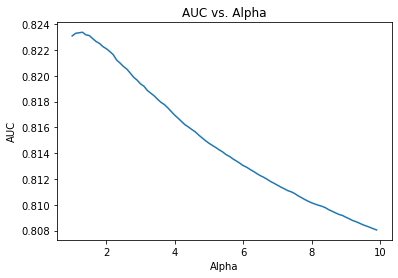

In [10]:
from sklearn.naive_bayes import MultinomialNB

res = pd.Series([get_auc_CV(MultinomialNB(i))
                 for i in np.arange(1, 10, 0.1)],
                index=np.arange(1, 10, 0.1))

best_alpha = np.round(res.idxmax(), 2)
print('Best alpha: ', best_alpha)

plt.plot(res)
plt.title('AUC vs. Alpha')
plt.xlabel('Alpha')
plt.ylabel('AUC')
plt.show()

In [11]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

AUC: 0.8451
Accuracy: 75.59%


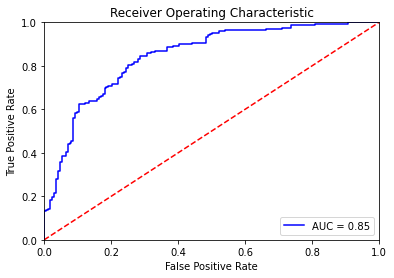

In [12]:
# Compute predicted probabilities
nb_model = MultinomialNB(alpha=1.8)
nb_model.fit(X_train_tfidf, y_train)
probs = nb_model.predict_proba(X_val_tfidf)

# Evaluate the classifier
evaluate_roc(probs, y_val)

In [14]:
#!pip install transformers

In [13]:
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [14]:
# Print sentence 0
print('Original: ', X[0])
print('Processed: ', text_preprocessing(X[0]))

Original:  @united I'm having issues. Yesterday I rebooked for 24 hours after I was supposed to fly, now I can't log on &amp; check in. Can you help?
Processed:  I'm having issues. Yesterday I rebooked for 24 hours after I was supposed to fly, now I can't log on & check in. Can you help?


In [15]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [16]:
# Concatenate train data and test data
all_tweets = np.concatenate([data.tweet.values, test_data.tweet.values])

# Encode our concatenated data
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_tweets]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)

Max length:  68


In [17]:
# Specify `MAX_LEN`
MAX_LEN = 64

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X[0]])[0].squeeze().numpy())
print('Original: ', X[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Original:  @united I'm having issues. Yesterday I rebooked for 24 hours after I was supposed to fly, now I can't log on &amp; check in. Can you help?
Token IDs:  [101, 1045, 1005, 1049, 2383, 3314, 1012, 7483, 1045, 2128, 8654, 2098, 2005, 2484, 2847, 2044, 1045, 2001, 4011, 2000, 4875, 1010, 2085, 1045, 2064, 1005, 1056, 8833, 2006, 1004, 4638, 1999, 1012, 2064, 2017, 2393, 1029, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tokenizing data...


C:\Users\nicol\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2226: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [18]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [19]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

Wall time: 18 ms


In [20]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [21]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [22]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.661765   |     -      |     -     |   75.96  
   1    |   40    |   0.530900   |     -      |     -     |   73.57  
   1    |   60    |   0.519993   |     -      |     -     |   71.01  
   1    |   80    |   0.482164   |     -      |     -     |   71.37  
   1    |   95    |   0.471428   |     -      |     -     |   52.71  
----------------------------------------------------------------------
   1    |    -    |   0.537809   |  0.450795  |   76.93   |  355.84  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |   20    |   0.299177   |     -      |     -     |   75.88  
   2    |   40    |   0.298271   |     -      |     -     |   72.

In [23]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

AUC: 0.8964
Accuracy: 80.29%


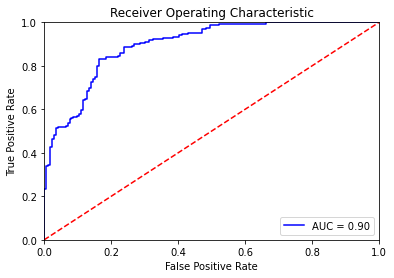

In [24]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, val_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, y_val)

In [25]:
# Concatenate the train set and the validation set
full_train_data = torch.utils.data.ConcatDataset([train_data, val_data])
full_train_sampler = RandomSampler(full_train_data)
full_train_dataloader = DataLoader(full_train_data, sampler=full_train_sampler, batch_size=32)

# Train the Bert Classifier on the entire training data
set_seed(42)
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, full_train_dataloader, epochs=2)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.669365   |     -      |     -     |   74.05  
   1    |   40    |   0.523132   |     -      |     -     |   71.73  
   1    |   60    |   0.551538   |     -      |     -     |   71.43  
   1    |   80    |   0.495202   |     -      |     -     |   71.53  
   1    |   100   |   0.486528   |     -      |     -     |   72.53  
   1    |   106   |   0.463321   |     -      |     -     |   18.89  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |   20    |   0.323701   |     -      |     -     |   75.05  
   2    |   40    |   0.285386   |     -      |     -     |   70.41  
   2    |   60    |   0.283467   |     -      |     -     |   71.5

In [26]:
test_data.sample(5)

,id,tweet
471,18654,Friends and family: Never fly @JetBlue. Absol...
1971,76265,@DeltaAssist @rogerioad I never have had a pro...
23,672,First flight in weeks. Counting on you @Americ...
2702,103263,"""@USAirways: You know that we can__t stay no m..."
135,5137,@southwestair Here at SA Airport watching the ...


In [49]:
torch.save(bert_classifier.state_dict(), os.path.join("C:\\Users\\nicol\\Documents\\Projet-programmation","bert_model.pt"))

In [46]:
bert_classifier

BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

In [ ]:
# Run `preprocessing_for_bert` on the test set
print('Tokenizing data...')
test_inputs, test_masks = preprocessing_for_bert(test_data.tweet)

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

In [ ]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, test_dataloader)

# Get predictions from the probabilities
threshold = 0.9
preds = np.where(probs[:, 1] > threshold, 1, 0)

# Number of tweets predicted non-negative
print("Number of tweets predicted non-negative: ", preds.sum())

In [ ]:
output = test_data[preds==1]
list(output.sample(20).tweet)

In [33]:
output

,id,tweet
3,159,Ok come on we are late let's goooo @united
12,409,@united oh man switched things up today and fl...
18,564,Shoutout to Crystal at @JetBlue for helping us...
19,569,@nicolevogelsong @SFGiants @united @flySFO nev...
23,672,First flight in weeks. Counting on you @Americ...
...,...,...
4522,172276,"Hey you guys, @JetBlue is the best. Seriously...."
4523,172295,AAANNNNDDD another reason to hate @united Preg...
4537,172913,@AbdulNasirJ @HussainKamani @united Prophet fu...
4542,173222,@walterbiscardi @united @CNN I hope CNN report...


In [54]:
probs[200:230]

array([[0.78329176, 0.21670824],
       [0.7436768 , 0.25632322],
       [0.1597257 , 0.84027433],
       [0.95757335, 0.04242661],
       [0.9567871 , 0.04321291],
       [0.9713579 , 0.02864205],
       [0.9655209 , 0.03447906],
       [0.87568605, 0.124314  ],
       [0.9243106 , 0.07568939],
       [0.03474764, 0.9652524 ],
       [0.686998  , 0.313002  ],
       [0.9660976 , 0.03390238],
       [0.71119696, 0.288803  ],
       [0.8708716 , 0.12912837],
       [0.8949352 , 0.10506479],
       [0.94046867, 0.05953135],
       [0.5042568 , 0.49574322],
       [0.5881047 , 0.41189522],
       [0.20146695, 0.798533  ],
       [0.9685412 , 0.03145876],
       [0.9674435 , 0.03255645],
       [0.873634  , 0.12636602],
       [0.21937329, 0.7806268 ],
       [0.9184933 , 0.08150677],
       [0.9551678 , 0.0448322 ],
       [0.9561075 , 0.04389252],
       [0.9690253 , 0.03097472],
       [0.22802146, 0.7719785 ],
       [0.2232184 , 0.77678156],
       [0.5454837 , 0.4545163 ]], dtype=flo

In [55]:
preds[200:230]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [56]:
import copy
import numpy as np
import pandas as pd
import requests
import time

from datetime import datetime 
from psaw import PushshiftAPI

In [57]:
api = PushshiftAPI()

In [59]:
#search for posts of the year 2021
start_epoch_2021 = int(datetime(2021, 1, 1).timestamp())
end_epoch_2021 = int(datetime(2021, 12, 31).timestamp())

api_request_generator_21 = api.search_submissions(
    after=start_epoch_2021,
    before=end_epoch_2021,
    subreddit='antiwork',
    limit=3000,
    score=">40"
)

df = pd.DataFrame([submission.d_ for submission in api_request_generator_21])

df["created_utc"] = df["created_utc"].apply(datetime.fromtimestamp)


In [60]:
df['date'] = pd.to_datetime(df['created_utc'], utc=True, unit='s')
df[['author', 'date', 'title', 'selftext', 'url', 'subreddit', 'score', 'num_comments', 'num_crossposts']].head(10)

,author,date,title,selftext,url,subreddit,score,num_comments,num_crossposts
0,creecher91,2021-12-09 07:08:38+00:00,Fuck them. Take a personal day.,,https://i.redd.it/uyph8y0jkg481.jpg,antiwork,57,2,0
1,MijoMijoMijo,2021-12-09 06:26:55+00:00,Strike on the 25th for 25$/hr !,,https://i.redd.it/p5y5eqt2dg481.jpg,antiwork,45,9,0
2,Beautiful__MJ,2021-12-09 06:22:33+00:00,I work at papa johns and this randomly printed...,,https://www.reddit.com/gallery/rcakj1,antiwork,81,5,0
3,Emmaline1986,2021-12-09 06:21:43+00:00,The company didn’t earn enough money for pay r...,,https://i.redd.it/97tfp6h5cg481.jpg,antiwork,68,3,0
4,AnimatorSufficient59,2021-12-09 06:20:32+00:00,I demanded a raise.,"Last week, a production supervisor on the crew...",https://www.reddit.com/r/antiwork/comments/rca...,antiwork,43,8,0
5,Fair-Inspection-8281,2021-12-09 06:10:49+00:00,Update: I went over my bosses head for a raise,So I received not only the $2 and hour I asked...,https://www.reddit.com/r/antiwork/comments/rca...,antiwork,80,9,0
6,BloominFunions,2021-12-09 06:09:35+00:00,Apply now! Kellogg is hiring scabs online. Let...,The workers at Kellogg’s cereal plants [have b...,https://www.reddit.com/r/antiwork/comments/rca...,antiwork,221,43,0
7,dobbyisafreepup,2021-12-09 06:01:58+00:00,Heartbreaking.,,https://i.redd.it/cc49tzsm8g481.jpg,antiwork,168,16,0
8,tyronewheresmychiken,2021-12-09 06:01:25+00:00,This fucking legend sharing poptarts recipe be...,,https://www.reddit.com/gallery/rca7nx,antiwork,64,2,0
9,UnlicencedAccountant,2021-12-09 05:55:49+00:00,I’M NOT WEARING HOCKEY PADS!!,,https://i.redd.it/a3jrkmcj7g481.jpg,antiwork,63,17,0


In [61]:
start_epoch=int(datetime(2021, 10, 1).timestamp())
end_epoch=int(datetime(2021, 12, 1).timestamp())

api_request_generator = api.search_comments(
                            after=start_epoch,
                            before = end_epoch,
                            limit=10000,
                            score = ">1000")

df2 = pd.DataFrame([submission.d_ for submission in api_request_generator])

df2["created_utc"] = df2["created_utc"].apply(datetime.fromtimestamp)

In [62]:
df2['body']

0          lol she's doing press, she loves the attention
1                                 I'm really sorry man :(
2                       I'd be head first out that window
3            Nah, that's dollar store daenerys targaryen.
4       Nope. Hence why there are only a few places th...
                              ...                        
9993                      "You may now bench the groom. "
9994                 We’re all disappointed in you, Doug.
9995    Surprise. Not sure what OP thinks milk is made...
9996    Aw, don't be mean to the little squid thingey....
9997    A heartfelt apology would go so much further w...
Name: body, Length: 9998, dtype: object

In [66]:
df2.columns

Index(['all_awardings', 'associated_award', 'author',
       'author_flair_background_color', 'author_flair_css_class',
       'author_flair_richtext', 'author_flair_template_id',
       'author_flair_text', 'author_flair_text_color', 'author_flair_type',
       'author_fullname', 'author_patreon_flair', 'author_premium', 'awarders',
       'body', 'collapsed_because_crowd_control', 'collapsed_reason_code',
       'comment_type', 'created_utc', 'gildings', 'id', 'is_submitter',
       'link_id', 'locked', 'no_follow', 'parent_id', 'permalink',
       'retrieved_on', 'score', 'send_replies', 'stickied', 'subreddit',
       'subreddit_id', 'top_awarded_type', 'total_awards_received',
       'treatment_tags', 'unrepliable_reason', 'created', 'author_cakeday',
       'distinguished', 'media_metadata', 'editable'],
      dtype='object')

In [69]:
df2 = df2[['created_utc','body']]

In [70]:
df2

,created_utc,body
0,2021-11-30 23:59:30,"lol she's doing press, she loves the attention"
1,2021-11-30 23:59:10,I'm really sorry man :(
2,2021-11-30 23:58:53,I'd be head first out that window
3,2021-11-30 23:58:34,"Nah, that's dollar store daenerys targaryen."
4,2021-11-30 23:58:21,Nope. Hence why there are only a few places th...
...,...,...
9993,2021-11-28 03:45:00,"""You may now bench the groom. """
9994,2021-11-28 03:44:55,"We’re all disappointed in you, Doug."
9995,2021-11-28 03:43:52,Surprise. Not sure what OP thinks milk is made...
9996,2021-11-28 03:43:15,"Aw, don't be mean to the little squid thingey...."


In [ ]:
reddit_data

In [ ]:
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)

In [72]:
reddit_data = DataLoader(sample_data_reddit, sampler=test_sampler, batch_size=32)

NameError: name 'sample_data_reddit' is not defined

In [ ]:
probs = bert_predict(bert_classifier, reddit_data)

In [101]:
test_inputs, test_masks = preprocessing_for_bert(df2.body)

test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

probs = bert_predict(bert_classifier, test_dataloader)

AttributeError: 'DataFrame' object has no attribute 'body'

In [99]:
probs[20:30]

array([[0.10216461, 0.8978354 ],
       [0.85842806, 0.14157194],
       [0.06236206, 0.937638  ],
       [0.2604982 , 0.7395018 ],
       [0.03486766, 0.96513236],
       [0.623518  , 0.37648195],
       [0.0841552 , 0.9158448 ],
       [0.14509241, 0.8549076 ],
       [0.38280687, 0.61719304],
       [0.10085488, 0.8991451 ]], dtype=float32)

In [100]:
for i in range(10):
    print(df2.body[20:30].loc[20+i])
    print( )
    print( )

Change it to their email address


My ex used to do this kind of crap. And now he lives in a separate house, and has to get up with the kids when he has them. I asked him to do more when we were together, and it never happened. One day, I had enough.

Ask your husband if this is what he wants.


Samwise Gamgee


There is nothing that suggests she can blood bend hundreds of people at once and even if she could there would be a lot of people there to stop her


you’re in the wrong sub, that is beautiful work and awesome as hell 😅


Fake gauge. You buy 1mm2/18AWG, you receive 0.5mm2/24AWG.


“Isn’t it a little early for ice cream?”
“We didn’t have any ice cream. This is mayonnaise and olives”


Same, then everybody on the bus looks at me funny.


To be fair I also have "less than 10" nukes.


Teacher here: 

This obviously might not be the case everywhere, but in every school I’ve been in (Saskatchewan, Canada) the police will be given keys to the rooms to clear out when safe. 

So they’d